In [1]:
import os
import sys
# Add src/ to sys.path (relative to current notebook)
sys.path.append(os.path.abspath("../../src"))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
import re

from utils.DataAnalysis import TableAnalysis, MyCustomException
from utils.VariableAnalysis import UnivariateAnalysis,BivariateAnalysis
from utils.pdf_file_save import PDFReportWriter

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',None)

In [2]:
file_path = pathlib.Path('D:\Capstone Project\dataset\House_Price_dataset')
df = pd.read_csv(f"{file_path}/4.gurgaon_properties_cleaned_v1.csv")
df.head()

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features
0,house,vipul tatvam villa,sector 48,7.35,22812.0,3222.0,Plot area 358(299.33 sq.m.),4,5,2,"servant room,store room,study room,pooja room",2.0,South,5 to 10 Year Old,"['Athena', 'Star Mall', 'The Sixth Element Sch...","['4 Wardrobe', '6 Fan', '1 Exhaust Fan', '14 L...","['Security / Fire Alarm', 'Feng Shui / Vaastu ..."
1,flat,signature global park,sohna road,0.54,6388.0,845.0,Super Built up area 845.3(78.53 sq.m.)Carpet a...,2,2,3,not available,4.0,East,0 to 1 Year Old,"['Sector 55-56 metro', 'Global city centre', '...",NaN,"['Security / Fire Alarm', 'Intercom Facility',..."
2,flat,godrej oasis,sector 88a,1.00,6896.0,1450.0,Carpet area: 1450 (134.71 sq.m.),2,2,3,study room,7.0,NaN,1 to 5 Year Old,"['Double Infinity market', 'Pataudi road', 'Dw...",NaN,"['Security / Fire Alarm', 'Power Back-up', 'Fe..."
3,flat,green court,sector 90,0.47,6811.0,690.0,Carpet area: 690 (64.1 sq.m.),2,2,1,not available,0.0,East,0 to 1 Year Old,"['Baba Kanala Chowk', 'Pataudi Rd', 'Gurukul P...","['3 Fan', '1 Exhaust Fan', '7 Light', 'No AC',...","['Feng Shui / Vaastu Compliant', 'Security / F..."
4,flat,m3m the marina,sector 68,2.22,14322.0,1550.0,Super Built up area 1550(144 sq.m.),3,2,3,not available,4.0,East,1 to 5 Year Old,"['Airia Mall', 'Southern Peripheral Road', 'So...","['6 Fan', '10 Light', '4 AC', 'No Bed', 'No Ch...","['Security / Fire Alarm', 'Intercom Facility',..."


In [3]:
df.duplicated().sum()

np.int64(121)

In [4]:
df.head(1)
# focus is on -> areaWithType, additionalRoom, agePossession, furnishDetails, features 

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features
0,house,vipul tatvam villa,sector 48,7.35,22812.0,3222.0,Plot area 358(299.33 sq.m.),4,5,2,"servant room,store room,study room,pooja room",2.0,South,5 to 10 Year Old,"['Athena', 'Star Mall', 'The Sixth Element Sch...","['4 Wardrobe', '6 Fan', '1 Exhaust Fan', '14 L...","['Security / Fire Alarm', 'Feng Shui / Vaastu ..."


## 1. areaWithType

In [5]:
df.sample(5)[['price','area','areaWithType']]

,price,area,areaWithType
1782,2.60,1715.0,Super Built up area 2450(227.61 sq.m.)Carpet a...
1110,1.73,2290.0,Super Built up area 2290(212.75 sq.m.)
3602,1.60,1910.0,Super Built up area 1910(177.44 sq.m.)Built Up...
2550,1.90,1975.0,Built Up area: 1975 (183.48 sq.m.)
1028,4.40,3500.0,Super Built up area 4200(390.19 sq.m.)Built Up...


In [6]:
# This function extracts the Super Built up area
def get_super_built_up_area(text):
    match = re.search(r'Super Built up area (\d+\.?\d*)', text)
    if match:
        return float(match.group(1))
    return None

In [7]:
# This function extracts the Built Up area or Carpet area
def get_area(text, area_type):
    match = re.search(area_type + r'\s*:\s*(\d+\.?\d*)', text)
    if match:
        return float(match.group(1))
    return None

In [8]:
# This function checks if the area is provided in sq.m. and converts it to sqft if needed
def convert_to_sqft(text, area_value):
    if area_value is None:
        return None
    match = re.search(r'{} \((\d+\.?\d*) sq.m.\)'.format(area_value), text)
    if match:
        sq_m_value = float(match.group(1))
        return sq_m_value * 10.7639  # conversion factor from sq.m. to sqft
    return area_value

In [9]:
# Extract Super Built up area and convert to sqft if needed
df['super_built_up_area'] = df['areaWithType'].apply(get_super_built_up_area)

df['super_built_up_area'] = df.apply(lambda x: convert_to_sqft(x['areaWithType'], x['super_built_up_area']), axis=1)

# Extract Built Up area and convert to sqft if needed
df['built_up_area'] = df['areaWithType'].apply(lambda x: get_area(x, 'Built Up area'))
df['built_up_area'] = df.apply(lambda x: convert_to_sqft(x['areaWithType'], x['built_up_area']), axis=1)

# Extract Carpet area and convert to sqft if needed
df['carpet_area'] = df['areaWithType'].apply(lambda x: get_area(x, 'Carpet area'))
df['carpet_area'] = df.apply(lambda x: convert_to_sqft(x['areaWithType'], x['carpet_area']), axis=1)

In [10]:
df[['price','property_type','area','areaWithType','super_built_up_area','built_up_area','carpet_area']].sample(5)

,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
3670,1.80,flat,1889.0,Super Built up area 1889(175.49 sq.m.),1889.0,NaN,NaN
1233,1.99,flat,963.0,Super Built up area 1349(125.33 sq.m.)Carpet a...,1349.0,NaN,963.0
1920,2.15,flat,1692.0,Super Built up area 1692(157.19 sq.m.)Built Up...,1692.0,1690.0,1592.0
1934,1.60,flat,1380.0,Carpet area: 1380 (128.21 sq.m.),NaN,NaN,1380.0
588,0.55,flat,950.0,Super Built up area 1115(103.59 sq.m.)Built Up...,1115.0,1050.0,950.0


In [11]:
df.duplicated().sum()

np.int64(121)

In [12]:
df[~((df['super_built_up_area'].isnull()) | (df['built_up_area'].isnull()) | (df['carpet_area'].isnull()))][['price','property_type','area','areaWithType','super_built_up_area','built_up_area','carpet_area']].shape

(534, 7)

In [13]:
## Property type House has Plot Area

df[df['areaWithType'].str.contains('Plot')][['price','property_type','area','areaWithType','super_built_up_area','built_up_area','carpet_area']]

,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
0,7.35,house,3222.0,Plot area 358(299.33 sq.m.),NaN,NaN,NaN
6,1.90,house,2250.0,Plot area 250(209.03 sq.m.)Carpet area: 190 sq...,NaN,NaN,190.0
8,4.00,house,1836.0,Plot area 204(170.57 sq.m.),NaN,NaN,NaN
10,1.40,house,1700.0,Plot area 1700(157.94 sq.m.),NaN,NaN,NaN
20,27.50,house,11286.0,Plot area 1254(1048.5 sq.m.),NaN,NaN,NaN
...,...,...,...,...,...,...,...
3735,0.92,house,603.0,Plot area 67(56.02 sq.m.),NaN,NaN,NaN
3751,1.60,house,558.0,Plot area 62(51.84 sq.m.),NaN,NaN,NaN
3775,4.65,house,2646.0,Plot area 294(245.82 sq.m.),NaN,NaN,NaN
3789,9.50,house,4050.0,Plot area 502(419.74 sq.m.)Built Up area: 500 ...,NaN,500.0,450.0


In [14]:
df.isnull().sum()

property_type             0
society                   1
sector                    0
price                    18
price_per_sqft           18
area                     18
areaWithType              0
bedRoom                   0
bathroom                  0
balcony                   0
additionalRoom            0
floorNum                 19
facing                 1105
agePossession             1
nearbyLocations         177
furnishDetails          981
features                635
super_built_up_area    1888
built_up_area          2616
carpet_area            1859
dtype: int64

In [15]:
## Nan Value for all newly Created Columns [super_built_up_area,built_up_area,carpet_area]
all_nan_df = df[((df['super_built_up_area'].isnull()) & (df['built_up_area'].isnull()) & (df['carpet_area'].isnull()))][['price','property_type','area','areaWithType','super_built_up_area','built_up_area','carpet_area']]

In [16]:
all_nan_df.head()

,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
0,7.35,house,3222.0,Plot area 358(299.33 sq.m.),NaN,NaN,NaN
8,4.00,house,1836.0,Plot area 204(170.57 sq.m.),NaN,NaN,NaN
10,1.40,house,1700.0,Plot area 1700(157.94 sq.m.),NaN,NaN,NaN
20,27.50,house,11286.0,Plot area 1254(1048.5 sq.m.),NaN,NaN,NaN
21,3.20,house,2250.0,Plot area 250(209.03 sq.m.),NaN,NaN,NaN


In [17]:
all_nan_index = df[((df['super_built_up_area'].isnull()) & (df['built_up_area'].isnull()) & (df['carpet_area'].isnull()))][['price','property_type','area','areaWithType','super_built_up_area','built_up_area','carpet_area']].index

In [18]:
# Function to extract plot area from 'areaWithType' column
def extract_plot_area(area_with_type):
    match = re.search(r'Plot area (\d+\.?\d*)', area_with_type)
    return float(match.group(1)) if match else None

In [19]:
all_nan_df['built_up_area'] = all_nan_df['areaWithType'].apply(extract_plot_area)

# Update the original dataframe
#gurgaon_properties.update(filtered_rows)

In [20]:
all_nan_df.head()

,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
0,7.35,house,3222.0,Plot area 358(299.33 sq.m.),NaN,358.0,NaN
8,4.00,house,1836.0,Plot area 204(170.57 sq.m.),NaN,204.0,NaN
10,1.40,house,1700.0,Plot area 1700(157.94 sq.m.),NaN,1700.0,NaN
20,27.50,house,11286.0,Plot area 1254(1048.5 sq.m.),NaN,1254.0,NaN
21,3.20,house,2250.0,Plot area 250(209.03 sq.m.),NaN,250.0,NaN


In [21]:
## Recalculating build up Area in to sq FEET  Metric since some areas are given in square yard.

def convert_scale(row):
    if np.isnan(row['area']) or np.isnan(row['built_up_area']):
        return row['built_up_area']
    else:
        if round(row['area']/row['built_up_area']) == 9.0:
            return row['built_up_area'] * 9
        elif round(row['area']/row['built_up_area']) == 11.0:
            return row['built_up_area'] * 10.7
        else:
            return row['built_up_area']

In [22]:
all_nan_df['built_up_area'] = all_nan_df.apply(convert_scale,axis=1)

In [23]:
all_nan_df

,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
0,7.35,house,3222.0,Plot area 358(299.33 sq.m.),NaN,3222.0,NaN
8,4.00,house,1836.0,Plot area 204(170.57 sq.m.),NaN,1836.0,NaN
10,1.40,house,1700.0,Plot area 1700(157.94 sq.m.),NaN,1700.0,NaN
20,27.50,house,11286.0,Plot area 1254(1048.5 sq.m.),NaN,11286.0,NaN
21,3.20,house,2250.0,Plot area 250(209.03 sq.m.),NaN,2250.0,NaN
...,...,...,...,...,...,...,...
3732,10.00,house,250.0,Plot area 250(23.23 sq.m.),NaN,250.0,NaN
3735,0.92,house,603.0,Plot area 67(56.02 sq.m.),NaN,603.0,NaN
3751,1.60,house,558.0,Plot area 62(51.84 sq.m.),NaN,558.0,NaN
3775,4.65,house,2646.0,Plot area 294(245.82 sq.m.),NaN,2646.0,NaN


In [24]:
# update the original dataframe
df.update(all_nan_df)

In [25]:
df.isnull().sum()

property_type             0
society                   1
sector                    0
price                    18
price_per_sqft           18
area                     18
areaWithType              0
bedRoom                   0
bathroom                  0
balcony                   0
additionalRoom            0
floorNum                 19
facing                 1105
agePossession             1
nearbyLocations         177
furnishDetails          981
features                635
super_built_up_area    1888
built_up_area          2070
carpet_area            1859
dtype: int64

In [26]:
df.head()

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features,super_built_up_area,built_up_area,carpet_area
0,house,vipul tatvam villa,sector 48,7.35,22812.0,3222.0,Plot area 358(299.33 sq.m.),4,5,2,"servant room,store room,study room,pooja room",2.0,South,5 to 10 Year Old,"['Athena', 'Star Mall', 'The Sixth Element Sch...","['4 Wardrobe', '6 Fan', '1 Exhaust Fan', '14 L...","['Security / Fire Alarm', 'Feng Shui / Vaastu ...",NaN,3222.0,NaN
1,flat,signature global park,sohna road,0.54,6388.0,845.0,Super Built up area 845.3(78.53 sq.m.)Carpet a...,2,2,3,not available,4.0,East,0 to 1 Year Old,"['Sector 55-56 metro', 'Global city centre', '...",NaN,"['Security / Fire Alarm', 'Intercom Facility',...",845.3,NaN,528.3
2,flat,godrej oasis,sector 88a,1.00,6896.0,1450.0,Carpet area: 1450 (134.71 sq.m.),2,2,3,study room,7.0,NaN,1 to 5 Year Old,"['Double Infinity market', 'Pataudi road', 'Dw...",NaN,"['Security / Fire Alarm', 'Power Back-up', 'Fe...",NaN,NaN,1450.0
3,flat,green court,sector 90,0.47,6811.0,690.0,Carpet area: 690 (64.1 sq.m.),2,2,1,not available,0.0,East,0 to 1 Year Old,"['Baba Kanala Chowk', 'Pataudi Rd', 'Gurukul P...","['3 Fan', '1 Exhaust Fan', '7 Light', 'No AC',...","['Feng Shui / Vaastu Compliant', 'Security / F...",NaN,NaN,690.0
4,flat,m3m the marina,sector 68,2.22,14322.0,1550.0,Super Built up area 1550(144 sq.m.),3,2,3,not available,4.0,East,1 to 5 Year Old,"['Airia Mall', 'Southern Peripheral Road', 'So...","['6 Fan', '10 Light', '4 AC', 'No Bed', 'No Ch...","['Security / Fire Alarm', 'Intercom Facility',...",1550.0,NaN,NaN


## 2.additionalRoom

In [27]:
df['additionalRoom'].value_counts()

additionalRoom
not available                                    1587
servant room                                      705
study room                                        250
others                                            225
pooja room                                        165
                                                 ... 
store room,pooja room,servant room,study room       1
servant room,study room,store room,pooja room       1
pooja room,store room,servant room                  1
servant room,pooja room,study room                  1
store room,servant room,study room,pooja room       1
Name: count, Length: 65, dtype: int64

In [28]:
# additional room
# List of new columns to be created
new_cols = ['study room', 'servant room', 'store room', 'pooja room', 'others']

# Populate the new columns based on the "additionalRoom" column
for col in new_cols:
    df[col] = df['additionalRoom'].str.contains(col).astype(int)

In [29]:
df.sample(5)[['additionalRoom','study room', 'servant room', 'store room', 'pooja room', 'others']]

,additionalRoom,study room,servant room,store room,pooja room,others
1961,"servant room,others",0,1,0,0,1
3773,not available,0,0,0,0,0
1415,"pooja room,servant room,store room",0,1,1,1,0
2330,"study room,servant room",1,1,0,0,0
2712,store room,0,0,1,0,0


In [30]:
df.head()

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others
0,house,vipul tatvam villa,sector 48,7.35,22812.0,3222.0,Plot area 358(299.33 sq.m.),4,5,2,"servant room,store room,study room,pooja room",2.0,South,5 to 10 Year Old,"['Athena', 'Star Mall', 'The Sixth Element Sch...","['4 Wardrobe', '6 Fan', '1 Exhaust Fan', '14 L...","['Security / Fire Alarm', 'Feng Shui / Vaastu ...",NaN,3222.0,NaN,1,1,1,1,0
1,flat,signature global park,sohna road,0.54,6388.0,845.0,Super Built up area 845.3(78.53 sq.m.)Carpet a...,2,2,3,not available,4.0,East,0 to 1 Year Old,"['Sector 55-56 metro', 'Global city centre', '...",NaN,"['Security / Fire Alarm', 'Intercom Facility',...",845.3,NaN,528.3,0,0,0,0,0
2,flat,godrej oasis,sector 88a,1.00,6896.0,1450.0,Carpet area: 1450 (134.71 sq.m.),2,2,3,study room,7.0,NaN,1 to 5 Year Old,"['Double Infinity market', 'Pataudi road', 'Dw...",NaN,"['Security / Fire Alarm', 'Power Back-up', 'Fe...",NaN,NaN,1450.0,1,0,0,0,0
3,flat,green court,sector 90,0.47,6811.0,690.0,Carpet area: 690 (64.1 sq.m.),2,2,1,not available,0.0,East,0 to 1 Year Old,"['Baba Kanala Chowk', 'Pataudi Rd', 'Gurukul P...","['3 Fan', '1 Exhaust Fan', '7 Light', 'No AC',...","['Feng Shui / Vaastu Compliant', 'Security / F...",NaN,NaN,690.0,0,0,0,0,0
4,flat,m3m the marina,sector 68,2.22,14322.0,1550.0,Super Built up area 1550(144 sq.m.),3,2,3,not available,4.0,East,1 to 5 Year Old,"['Airia Mall', 'Southern Peripheral Road', 'So...","['6 Fan', '10 Light', '4 AC', 'No Bed', 'No Ch...","['Security / Fire Alarm', 'Intercom Facility',...",1550.0,NaN,NaN,0,0,0,0,0


## 3.agePossession

In [31]:
df['agePossession'].value_counts()

agePossession
1 to 5 Year Old       1676
5 to 10 Year Old       575
0 to 1 Year Old        530
undefined              332
10+ Year Old           310
Under Construction      90
Within 6 months         70
Within 3 months         26
Dec 2023                22
By 2023                 19
By 2024                 17
Dec 2024                16
Mar 2024                14
Jan 2024                 8
Oct 2024                 8
Jun 2024                 7
Dec 2025                 7
Aug 2023                 7
Nov 2023                 5
Jul 2024                 4
Sep 2023                 4
Oct 2023                 4
By 2025                  4
Aug 2024                 4
Feb 2024                 3
Jan 2025                 3
Nov 2024                 3
May 2024                 3
Oct 2025                 2
Jul 2025                 2
By 2027                  2
Apr 2026                 2
Mar 2025                 2
Dec 2026                 2
Aug 2025                 2
Sep 2025                 2
Jun 2027      

In [32]:
## categorical valu of agePossesion Binning in to category 

def categorize_age_possession(value):
    if pd.isna(value):
        return "Undefined"
    if "0 to 1 Year Old" in value or "Within 6 months" in value or "Within 3 months" in value:
        return "New Property"
    if "1 to 5 Year Old" in value:
        return "Relatively New"
    if "5 to 10 Year Old" in value:
        return "Moderately Old"
    if "10+ Year Old" in value:
        return "Old Property"
    if "Under Construction" in value or "By" in value:
        return "Under Construction"
    try:
        # For entries like 'May 2024'
        int(value.split(" ")[-1])
        return "Under Construction"
    except:
        return "Undefined"

In [33]:
df['agePossession'] = df['agePossession'].apply(categorize_age_possession)

In [34]:
df['agePossession'].value_counts()

agePossession
Relatively New        1676
New Property           626
Moderately Old         575
Undefined              333
Old Property           310
Under Construction     283
Name: count, dtype: int64

In [35]:
df.head()

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others
0,house,vipul tatvam villa,sector 48,7.35,22812.0,3222.0,Plot area 358(299.33 sq.m.),4,5,2,"servant room,store room,study room,pooja room",2.0,South,Moderately Old,"['Athena', 'Star Mall', 'The Sixth Element Sch...","['4 Wardrobe', '6 Fan', '1 Exhaust Fan', '14 L...","['Security / Fire Alarm', 'Feng Shui / Vaastu ...",NaN,3222.0,NaN,1,1,1,1,0
1,flat,signature global park,sohna road,0.54,6388.0,845.0,Super Built up area 845.3(78.53 sq.m.)Carpet a...,2,2,3,not available,4.0,East,New Property,"['Sector 55-56 metro', 'Global city centre', '...",NaN,"['Security / Fire Alarm', 'Intercom Facility',...",845.3,NaN,528.3,0,0,0,0,0
2,flat,godrej oasis,sector 88a,1.00,6896.0,1450.0,Carpet area: 1450 (134.71 sq.m.),2,2,3,study room,7.0,NaN,Relatively New,"['Double Infinity market', 'Pataudi road', 'Dw...",NaN,"['Security / Fire Alarm', 'Power Back-up', 'Fe...",NaN,NaN,1450.0,1,0,0,0,0
3,flat,green court,sector 90,0.47,6811.0,690.0,Carpet area: 690 (64.1 sq.m.),2,2,1,not available,0.0,East,New Property,"['Baba Kanala Chowk', 'Pataudi Rd', 'Gurukul P...","['3 Fan', '1 Exhaust Fan', '7 Light', 'No AC',...","['Feng Shui / Vaastu Compliant', 'Security / F...",NaN,NaN,690.0,0,0,0,0,0
4,flat,m3m the marina,sector 68,2.22,14322.0,1550.0,Super Built up area 1550(144 sq.m.),3,2,3,not available,4.0,East,Relatively New,"['Airia Mall', 'Southern Peripheral Road', 'So...","['6 Fan', '10 Light', '4 AC', 'No Bed', 'No Ch...","['Security / Fire Alarm', 'Intercom Facility',...",1550.0,NaN,NaN,0,0,0,0,0


## 4.furnishDetails

In [36]:
df.sample(5)[['furnishDetails','features']]

,furnishDetails,features
2196,NaN,"['Water purifier', 'Centrally Air Conditioned'..."
1851,"['1 Water Purifier', '6 Fan', '1 Exhaust Fan',...","['Feng Shui / Vaastu Compliant', 'Private Gard..."
3675,"['1 Wardrobe', '1 Fan', '1 Light', 'No AC', 'N...",NaN
228,"['1 Light', 'No AC', 'No Bed', 'No Chimney', '...",NaN
886,"['1 Water Purifier', '5 Fan', '1 Exhaust Fan',...","['Security / Fire Alarm', 'Power Back-up', 'Fe..."


In [37]:
# Extract all unique furnishings from the furnishDetails column
all_furnishings = []
for detail in df['furnishDetails'].dropna():
    furnishings = detail.replace('[', '').replace(']', '').replace("'", "").split(', ')
    all_furnishings.extend(furnishings)
unique_furnishings = list(set(all_furnishings))

# Define a function to extract the count of a furnishing from the furnishDetails
def get_furnishing_count(details, furnishing):
    if isinstance(details, str):
        if f"No {furnishing}" in details:
            return 0
        pattern = re.compile(f"(\d+) {furnishing}")
        match = pattern.search(details)
        if match:
            return int(match.group(1))
        elif furnishing in details:
            return 1
    return 0

# Simplify the furnishings list by removing "No" prefix and numbers
columns_to_include = [re.sub(r'No |\d+', '', furnishing).strip() for furnishing in unique_furnishings]
columns_to_include = list(set(columns_to_include))  # Get unique furnishings
columns_to_include = [furnishing for furnishing in columns_to_include if furnishing]  # Remove empty strings

# Create new columns for each unique furnishing and populate with counts
for furnishing in columns_to_include:
    df[furnishing] = df['furnishDetails'].apply(lambda x: get_furnishing_count(x, furnishing))

# Create the new dataframe with the required columns
furnishings_df = df[['furnishDetails'] + columns_to_include]


In [38]:
furnishings_df.shape

(3803, 19)

In [39]:
furnishings_df.sample(5)

,furnishDetails,Light,Sofa,Microwave,Bed,Modular Kitchen,AC,Water Purifier,Fridge,Wardrobe,Washing Machine,TV,Stove,Dining Table,Geyser,Exhaust Fan,Fan,Chimney,Curtains
1558,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2720,"['3 Fan', '1 Exhaust Fan', '3 Light', 'No AC',...",3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3,0,0
223,"['6 Fan', '1 Exhaust Fan', '5 Geyser', '19 Lig...",19,0,0,0,1,7,0,0,6,0,0,0,0,5,1,6,1,1
1986,"['10 Light', '4 AC', 'No Bed', 'No Chimney', '...",10,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0
203,"['4 Fan', '8 Light', 'No AC', 'No Bed', 'No Ch...",8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0


In [40]:
furnishings_df.drop(columns=['furnishDetails'],inplace=True)
furnishings_df.sample(5)

,Light,Sofa,Microwave,Bed,Modular Kitchen,AC,Water Purifier,Fridge,Wardrobe,Washing Machine,TV,Stove,Dining Table,Geyser,Exhaust Fan,Fan,Chimney,Curtains
2430,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1836,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1959,10,0,0,0,1,0,0,0,0,0,0,0,0,3,1,5,0,0
2894,20,0,0,0,1,6,0,0,5,0,0,0,0,0,1,7,0,0
3568,12,0,1,0,1,5,0,1,5,1,0,1,0,6,1,6,1,6


In [41]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [42]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(furnishings_df)

In [43]:
wcss_reduced = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(scaled_data)
    wcss_reduced.append(kmeans.inertia_)

  File "c:\Users\mayal\anaconda3\envs\ds_generic\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\mayal\anaconda3\envs\ds_generic\lib\subprocess.py", line 505, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\mayal\anaconda3\envs\ds_generic\lib\subprocess.py", line 951, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\mayal\anaconda3\envs\ds_generic\lib\subprocess.py", line 1436, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


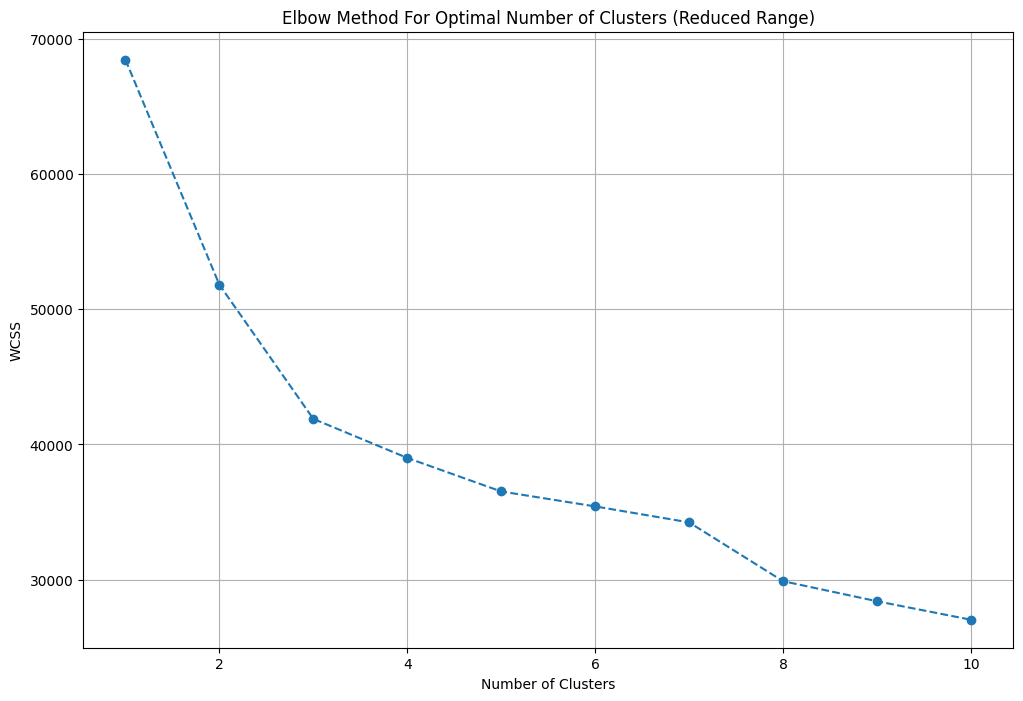

In [44]:
# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(range(1,11), wcss_reduced, marker='o', linestyle='--')
plt.title('Elbow Method For Optimal Number of Clusters (Reduced Range)')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

In [45]:
n_clusters = 3

# Fit the KMeans model
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(scaled_data)

# Predict the cluster assignments for each row
cluster_assignments = kmeans.predict(scaled_data)

In [46]:
df = df.iloc[:,:-18]

In [47]:
df['furnishing_type'] = cluster_assignments

In [48]:
df.sample(5)[['furnishDetails','furnishing_type']]
# 0 -> unfurnished
# 1 -> semifurnished
# 2 -> furnished

,furnishDetails,furnishing_type
1173,"['1 Fan', '1 Light', '1 Modular Kitchen', 'No ...",0
2053,NaN,0
1774,[],0
3637,NaN,0
1281,NaN,0


## 5.features

In [49]:
df[['society','features']].sample(5)

,society,features
1713,ansal heights 86,"['Security / Fire Alarm', 'Intercom Facility',..."
2856,independent,"['Feng Shui / Vaastu Compliant', 'Private Gard..."
919,gls avenue 51,NaN
2284,godrej,"['Centrally Air Conditioned', 'Security / Fire..."
2019,ansal housing highland park,NaN


In [50]:
df['features'].isnull().sum()

np.int64(635)

In [51]:
import pandas as pd
app_df = pd.read_csv(f'{file_path}/appartments.csv')
app_df.head(2)

,PropertyName,PropertySubName,NearbyLocations,LocationAdvantages,Link,PriceDetails,TopFacilities
0,Smartworld One DXP,"2, 3, 4 BHK Apartment in Sector 113, Gurgaon","['Bajghera Road', 'Palam Vihar Halt', 'DPSG Pa...","{'Bajghera Road': '800 Meter', 'Palam Vihar Ha...",https://www.99acres.com/smartworld-one-dxp-sec...,"{'2 BHK': {'building_type': 'Apartment', 'area...","['Swimming Pool', 'Salon', 'Restaurant', 'Spa'..."
1,M3M Crown,"3, 4 BHK Apartment in Sector 111, Gurgaon","['DPSG Palam Vihar Gurugram', 'The NorthCap Un...","{'DPSG Palam Vihar Gurugram': '1.4 Km', 'The N...",https://www.99acres.com/m3m-crown-sector-111-g...,"{'3 BHK': {'building_type': 'Apartment', 'area...","['Bowling Alley', 'Mini Theatre', 'Manicured G..."


In [52]:
app_df['PropertyName'] = app_df['PropertyName'].str.lower()

In [53]:
temp_df = df[df['features'].isnull()]

In [54]:
temp_df.shape

(635, 26)

In [55]:
x = temp_df.merge(app_df,left_on='society',right_on='PropertyName',how='left')['TopFacilities']

In [56]:
df.loc[temp_df.index,'features'] = x.values

In [57]:
df['features'].isnull().sum()

np.int64(481)

In [58]:
from sklearn.preprocessing import MultiLabelBinarizer
import ast

In [59]:
# Convert the string representation of lists in the 'features' column to actual lists
df['features_list'] = df['features'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) and x.startswith('[') else [])

# Use MultiLabelBinarizer to convert the features list into a binary matrix
mlb = MultiLabelBinarizer()
features_binary_matrix = mlb.fit_transform(df['features_list'])

# Convert the binary matrix into a DataFrame
features_binary_df = pd.DataFrame(features_binary_matrix, columns=mlb.classes_)

In [60]:
features_binary_df.sample(5)

,24/7 Power Backup,24/7 Water Supply,24x7 Security,ATM,Aerobics Centre,Air Hockey,Airy Rooms,Amphitheatre,Automated Car Wash,Badminton Court,Bank Attached Property,Banquet Hall,Bar/Chill-Out Lounge,Barbecue,Basketball Court,Beach Volley Ball Court,Billiards,Bowling Alley,Bus Shelter,Business Lounge,CCTV Camera Security,Cafeteria,Car Parking,Car wash area,Card Room,Centrally Air Conditioned,Changing Area,Children's Play Area,Cigar Lounge,Clinic,Club House,Club house / Community Center,Community Hall,Concierge Service,Conference room,Creche/Day care,Cricket Pitch,Doctor on Call,Earthquake Resistant,Entrance Lobby,False Ceiling Lighting,Feng Shui / Vaastu Compliant,Fire Fighting Systems,Fitness Centre / GYM,Flower Garden,Food Court,Foosball,Football,Fountain,Gated Community,Gazebo,Golf Course,Grocery Shop,Gymnasium,High Ceiling Height,High Speed Elevators,Infinity Pool,Intercom Facility,Internal Street Lights,Internet/wi-fi connectivity,Jacuzzi,Jogging Track,Landscape Garden,Laundry,Lawn Tennis Court,Library,Lift(s),Lounge,Low Density Society,Maintenance Staff,Manicured Garden,Medical Centre,Milk Booth,Mini Theatre,Multipurpose Court,Multipurpose Hall,Natural Light,Natural Pond,No open drainage around,Park,Party Lawn,Pergola,Piped Gas,Piped-gas,Pool Table,Power Back up Lift,Power Back-up,Private Garden / Terrace,Property Staff,RO System,Rain Water Harvesting,Reading Lounge,Recently Renovated,Reflexology Park,Restaurant,Salon,Sauna,School,Security / Fire Alarm,Security Personnel,Separate entry for servant room,Sewage Treatment Plant,Shopping Centre,Skating Rink,Solar Lighting,Solar Water Heating,Spa,Spacious Interiors,Squash Court,Steam Room,Sun Deck,Swimming Pool,Temple,Terrace Garden,Theatre,Toddler Pool,Valet Parking,Vastu Compliant,Video Door Security,Visitor Parking,Visitors Parking,Volley Ball Court,Waiting Lounge,Waste Disposal,Water Softener Plant,Water Storage,Water purifier,Water softening plant,Wi-Fi Connectivity,Yoga/Meditation Area
1337,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1952,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0
1651,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,1,0,1,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1,1,0,0
3772,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0
517,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1,0,0,0


In [61]:
features_binary_df.shape

(3803, 130)

In [62]:
wcss_reduced = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(features_binary_df)
    wcss_reduced.append(kmeans.inertia_)

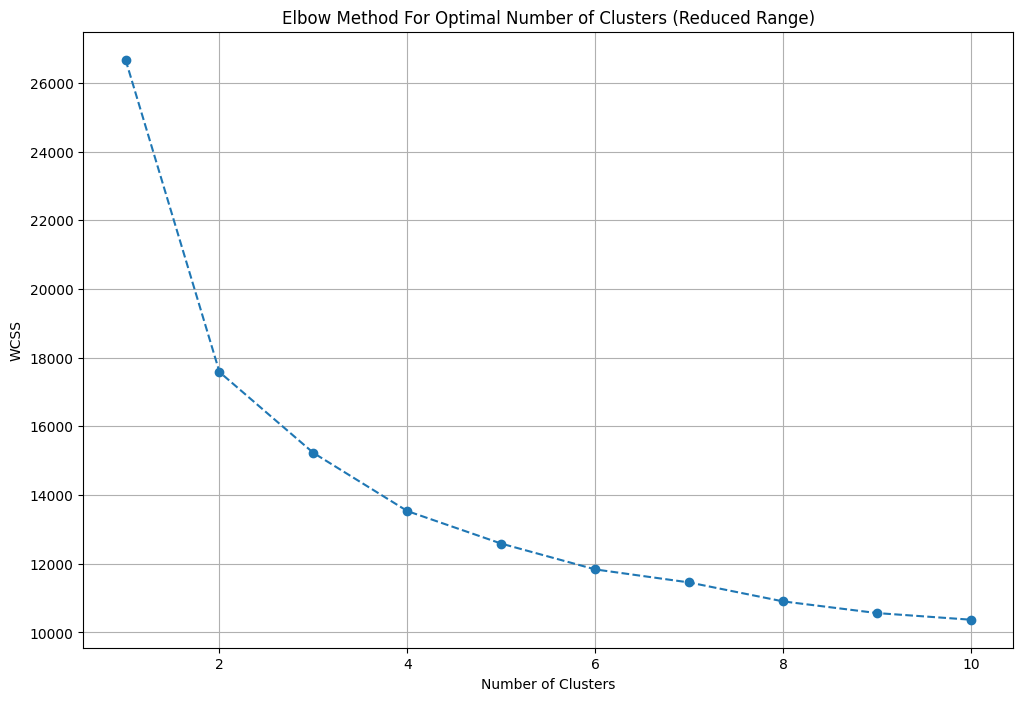

In [63]:
# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(range(1,11), wcss_reduced, marker='o', linestyle='--')
plt.title('Elbow Method For Optimal Number of Clusters (Reduced Range)')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

In [64]:
# Define the weights for each feature as provided
# Assigning weights based on perceived luxury contribution
weights = {
    '24/7 Power Backup': 8,
    '24/7 Water Supply': 4,
    '24x7 Security': 7,
    'ATM': 4,
    'Aerobics Centre': 6,
    'Airy Rooms': 8,
    'Amphitheatre': 7,
    'Badminton Court': 7,
    'Banquet Hall': 8,
    'Bar/Chill-Out Lounge': 9,
    'Barbecue': 7,
    'Basketball Court': 7,
    'Billiards': 7,
    'Bowling Alley': 8,
    'Business Lounge': 9,
    'CCTV Camera Security': 8,
    'Cafeteria': 6,
    'Car Parking': 6,
    'Card Room': 6,
    'Centrally Air Conditioned': 9,
    'Changing Area': 6,
    "Children's Play Area": 7,
    'Cigar Lounge': 9,
    'Clinic': 5,
    'Club House': 9,
    'Concierge Service': 9,
    'Conference room': 8,
    'Creche/Day care': 7,
    'Cricket Pitch': 7,
    'Doctor on Call': 6,
    'Earthquake Resistant': 5,
    'Entrance Lobby': 7,
    'False Ceiling Lighting': 6,
    'Feng Shui / Vaastu Compliant': 5,
    'Fire Fighting Systems': 8,
    'Fitness Centre / GYM': 8,
    'Flower Garden': 7,
    'Food Court': 6,
    'Foosball': 5,
    'Football': 7,
    'Fountain': 7,
    'Gated Community': 7,
    'Golf Course': 10,
    'Grocery Shop': 6,
    'Gymnasium': 8,
    'High Ceiling Height': 8,
    'High Speed Elevators': 8,
    'Infinity Pool': 9,
    'Intercom Facility': 7,
    'Internal Street Lights': 6,
    'Internet/wi-fi connectivity': 7,
    'Jacuzzi': 9,
    'Jogging Track': 7,
    'Landscape Garden': 8,
    'Laundry': 6,
    'Lawn Tennis Court': 8,
    'Library': 8,
    'Lounge': 8,
    'Low Density Society': 7,
    'Maintenance Staff': 6,
    'Manicured Garden': 7,
    'Medical Centre': 5,
    'Milk Booth': 4,
    'Mini Theatre': 9,
    'Multipurpose Court': 7,
    'Multipurpose Hall': 7,
    'Natural Light': 8,
    'Natural Pond': 7,
    'Park': 8,
    'Party Lawn': 8,
    'Piped Gas': 7,
    'Pool Table': 7,
    'Power Back up Lift': 8,
    'Private Garden / Terrace': 9,
    'Property Staff': 7,
    'RO System': 7,
    'Rain Water Harvesting': 7,
    'Reading Lounge': 8,
    'Restaurant': 8,
    'Salon': 8,
    'Sauna': 9,
    'Security / Fire Alarm': 9,
    'Security Personnel': 9,
    'Separate entry for servant room': 8,
    'Sewage Treatment Plant': 6,
    'Shopping Centre': 7,
    'Skating Rink': 7,
    'Solar Lighting': 6,
    'Solar Water Heating': 7,
    'Spa': 9,
    'Spacious Interiors': 9,
    'Squash Court': 8,
    'Steam Room': 9,
    'Sun Deck': 8,
    'Swimming Pool': 8,
    'Temple': 5,
    'Theatre': 9,
    'Toddler Pool': 7,
    'Valet Parking': 9,
    'Video Door Security': 9,
    'Visitor Parking': 7,
    'Water Softener Plant': 7,
    'Water Storage': 7,
    'Water purifier': 7,
    'Yoga/Meditation Area': 7
}
# Calculate luxury score for each row
luxury_score = features_binary_df[list(weights.keys())].multiply(list(weights.values())).sum(axis=1)


In [65]:
df['luxury_score'] = luxury_score

In [66]:
df.head()

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others,furnishing_type,features_list,luxury_score
0,house,vipul tatvam villa,sector 48,7.35,22812.0,3222.0,Plot area 358(299.33 sq.m.),4,5,2,"servant room,store room,study room,pooja room",2.0,South,Moderately Old,"['Athena', 'Star Mall', 'The Sixth Element Sch...","['4 Wardrobe', '6 Fan', '1 Exhaust Fan', '14 L...","['Security / Fire Alarm', 'Feng Shui / Vaastu ...",NaN,3222.0,NaN,1,1,1,1,0,2,"[Security / Fire Alarm, Feng Shui / Vaastu Com...",144
1,flat,signature global park,sohna road,0.54,6388.0,845.0,Super Built up area 845.3(78.53 sq.m.)Carpet a...,2,2,3,not available,4.0,East,New Property,"['Sector 55-56 metro', 'Global city centre', '...",NaN,"['Security / Fire Alarm', 'Intercom Facility',...",845.3,NaN,528.3,0,0,0,0,0,0,"[Security / Fire Alarm, Intercom Facility, Lif...",44
2,flat,godrej oasis,sector 88a,1.00,6896.0,1450.0,Carpet area: 1450 (134.71 sq.m.),2,2,3,study room,7.0,NaN,Relatively New,"['Double Infinity market', 'Pataudi road', 'Dw...",NaN,"['Security / Fire Alarm', 'Power Back-up', 'Fe...",NaN,NaN,1450.0,1,0,0,0,0,0,"[Security / Fire Alarm, Power Back-up, Feng Sh...",72
3,flat,green court,sector 90,0.47,6811.0,690.0,Carpet area: 690 (64.1 sq.m.),2,2,1,not available,0.0,East,New Property,"['Baba Kanala Chowk', 'Pataudi Rd', 'Gurukul P...","['3 Fan', '1 Exhaust Fan', '7 Light', 'No AC',...","['Feng Shui / Vaastu Compliant', 'Security / F...",NaN,NaN,690.0,0,0,0,0,0,0,"[Feng Shui / Vaastu Compliant, Security / Fire...",49
4,flat,m3m the marina,sector 68,2.22,14322.0,1550.0,Super Built up area 1550(144 sq.m.),3,2,3,not available,4.0,East,Relatively New,"['Airia Mall', 'Southern Peripheral Road', 'So...","['6 Fan', '10 Light', '4 AC', 'No Bed', 'No Ch...","['Security / Fire Alarm', 'Intercom Facility',...",1550.0,NaN,NaN,0,0,0,0,0,0,"[Security / Fire Alarm, Intercom Facility, Lif...",44


In [67]:
# cols to drop -> nearbyLocations,furnishDetails, features,features_list, additionalRoom
df.drop(columns=['nearbyLocations','furnishDetails','features','features_list','additionalRoom'],inplace=True)

In [68]:
df.sample(5)

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,floorNum,facing,agePossession,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others,furnishing_type,luxury_score
1793,flat,sare homes,sector 92,1.1,5347.0,2057.0,Carpet area: 2057 (191.1 sq.m.),4,4,3,4.0,North-West,Relatively New,NaN,NaN,2057.00,0,1,0,0,0,0,108
3032,flat,ansal plaza,sector 2,1.0,10000.0,1000.0,Built Up area: 1000 (92.9 sq.m.),2,3,0,1.0,NaN,Undefined,NaN,1000.0,NaN,0,0,0,0,0,0,0
2915,flat,ireo the corridors,sector 67a,1.8,14658.0,1228.0,Super Built up area 1921(178.47 sq.m.)Carpet a...,3,3,3,6.0,North,New Property,1921.0,NaN,1227.96,0,1,1,0,0,2,150
3065,flat,sidhartha ncr one phase,sector 95,0.6,4800.0,1250.0,Built Up area: 1250 (116.13 sq.m.),2,2,3,10.0,North-East,Undefined,NaN,1250.0,NaN,0,0,0,0,0,0,0
1687,flat,landmark the residency,sector 103,0.9,6666.0,1350.0,Super Built up area 1350(125.42 sq.m.),2,2,2,1.0,South-West,Relatively New,1350.0,NaN,NaN,0,0,0,0,0,0,44


In [69]:
df.shape

(3803, 23)

In [70]:
df.iloc[1254:]

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,floorNum,facing,agePossession,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others,furnishing_type,luxury_score
1254,flat,bestech park view residency,sector 2,1.02,7208.0,1415.0,Super Built up area 1415(131.46 sq.m.),2,2,3,11.0,South-West,Moderately Old,1415.0,NaN,NaN,0,0,0,0,0,0,92
1255,flat,experion the heartsong,sector 108,1.60,7988.0,2003.0,Super Built up area 2003(186.08 sq.m.)Built Up...,3,4,3+,3.0,South,Relatively New,2003.0,1500.29,1140.98,0,1,0,0,0,2,60
1256,flat,imperia the esfera,sector 37c,0.87,5513.0,1578.0,Super Built up area 1578(146.6 sq.m.)Built Up ...,2,3,3+,5.0,North-West,Relatively New,1578.0,1300.00,1110.00,1,0,0,0,0,0,109
1257,flat,guru gram haryana cghs,sector 56,1.39,8424.0,1650.0,Super Built up area 1850(171.87 sq.m.)Built Up...,3,2,3,6.0,South,Old Property,1850.0,1750.00,1650.00,0,1,0,1,0,2,89
1258,house,independent,sector 36,0.75,6938.0,1081.0,Built Up area: 1081 (100.43 sq.m.),3,1,0,1.0,NaN,Undefined,NaN,1081.00,NaN,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3798,flat,dlf the primus,sector 82a,1.85,10176.0,1818.0,Super Built up area 1818(168.9 sq.m.)Carpet ar...,3,3,3,15.0,East,Moderately Old,1818.0,NaN,1538.00,0,0,0,0,1,0,38
3799,flat,experion the heartsong,sector 108,1.36,6542.0,2079.0,Super Built up area 1758(163.32 sq.m.)Carpet a...,3,2,3+,2.0,NaN,Relatively New,1758.0,NaN,986.00,1,1,0,0,0,2,77
3800,house,independent,sector 7,1.95,13542.0,1440.0,Plot area 160(133.78 sq.m.),2,2,2,2.0,NaN,Old Property,NaN,1440.00,NaN,0,0,0,0,0,0,0
3801,flat,dlf regal gardens,sector 90,1.29,7103.0,1816.0,Super Built up area 1818(168.9 sq.m.)Built Up ...,3,3,3+,12.0,South-East,Relatively New,1818.0,1817.00,1816.00,0,1,0,0,0,0,152


In [71]:
df.to_csv(f'{file_path}/5.gurgaon_properties_cleaned_v2.csv',index=False)